<a href="https://colab.research.google.com/github/bhuvishi/llm_understanding/blob/main/Model_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets transformers transformers[torch] transformers[deepspeed] accelerate nvidia-ml-py3 -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.5/851.5 kB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print(torch.cuda.get_device_capability())

(8, 0)


In [ ]:
import datasets
import gensim
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
import re
import sklearn.manifold


class DataMangler(object):

  def __init__(self, dir_path=None, dataset_dict=None, num_lda_training_passes=20, max_num_data_points=10000000,
               print_stats=True):
    if dir_path:
      self._load(dir_path)
      if print_stats:
        self._print_stats(dir_path)
      return

    self._train_df = pd.DataFrame(dataset_dict["train"])[:max_num_data_points]
    self._validation_df = pd.DataFrame(dataset_dict["validation"])[:max_num_data_points]

    all_data = pd.concat([self._train_df, self._validation_df])
    all_data_grouped = self._get_dataframe_with_text_column(all_data)
    all_data_grouped["text"] = self._process_text(all_data_grouped["text"])

    self._lda_model = LDAModel(texts=all_data_grouped["text"], passes=num_lda_training_passes)
    doc_lda = self._lda_model.inferTopics(all_data_grouped["text"])
    all_data_grouped['topic'] = self._get_topic_with_highest_prob(doc_lda)
    all_data_grouped.drop(['text'], axis=1)

    all_data_grouped = all_data_grouped.explode('id').set_index('id')

    self._train_df = self._train_df.join(all_data_grouped, on='id')

    self._validation_df = self._validation_df.join(all_data_grouped, on='id')
    self._all_data_grouped = all_data_grouped

    #self._create_tsne_model_and_plot(doc_lda)

  def _print_stats(self, dir_path):
    all_data = pd.concat([self._train_df, self._validation_df])
    self._all_data_grouped = self._get_dataframe_with_text_column(all_data)
    self._all_data_grouped["text"] = self._process_text(self._all_data_grouped["text"])

    doc_lda = self._lda_model.inferTopics(self._all_data_grouped["text"])
    self._create_tsne_model_and_plot(doc_lda)

    self._all_data_grouped['topic'] = self._get_topic_with_highest_prob(doc_lda)
    corpus = [self._lda_model._id2word.doc2bow(text) for text in self._all_data_grouped["text"]]
    with open(os.path.join(dir_path, 'topics_summary.txt'), 'w') as f:
        pprint(self._lda_model._lda_model.print_topics(), stream=f)

        f.write('\n\nLDA model\'s perplexity: ' + str(self._lda_model._lda_model.log_perplexity(corpus)))

    sampled_data_by_topics = self._all_data_grouped.groupby("topic").sample(n=50, random_state=1)
    with open(os.path.join(dir_path, 'sampled_contexts_by_topics.txt'), 'w') as f:
      for topic in range(10):
        f.write(F'Topic {topic}\n')
        for context in sampled_data_by_topics[sampled_data_by_topics['topic'] == topic]['context']:
          f.write(context)
          f.write('\n\n')
        f.write('\n\n\n\n\n')


  def _load(self, dir_path):
    train_path, validation_path, all_data_grouped_path, lda_model_path = (
        self._get_save_paths(dir_path))
    self._train_df = pd.read_pickle(train_path)
    self._validation_df = pd.read_pickle(validation_path)
    self._all_data_grouped = pd.read_pickle(all_data_grouped_path)
    self._lda_model = LDAModel(dir_path=lda_model_path)

  def save(self, dir_path):
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)

    train_path, validation_path, all_data_grouped_path, lda_model_path = (
        self._get_save_paths(dir_path))
    self._train_df.to_pickle(train_path)
    self._validation_df.to_pickle(validation_path)
    self._all_data_grouped.to_pickle(all_data_grouped_path)
    self._lda_model.save(lda_model_path)

  def _get_save_paths(self, dir_path):
    return (os.path.join(dir_path, 'train_df.pkl'),
            os.path.join(dir_path, 'validation_df.pkl'),
            os.path.join(dir_path, 'all_data_grouped_df.pkl'),
            os.path.join(dir_path, 'lda_model'))

  def get_updated_dataset_dict(self):
    dataset_dict = datasets.DatasetDict()
    dataset_dict['train'] = datasets.Dataset.from_pandas(self._train_df)
    dataset_dict['validation'] = datasets.Dataset.from_pandas(self._validation_df)
    return dataset_dict

  def inferTopics(self, text):
    doc_lda = self._lda_model.inferTopics(all_data_grouped["text"])
    return self._get_topic_index_with_highest_prob(doc_lda)

  def _get_dataframe_with_text_column(self, df):
    grouped = df.groupby(by=["title", "context"], as_index=False).agg({'id': pd.Series.to_list})
    grouped["text"] = grouped['title'] + " " + grouped['context']
    # grouped = grouped.drop(["title", "context"], axis=1)
    return grouped

  def _process_text(self, text):
    # Remove punctuation
    processed = text.map(lambda x: re.sub('[,\.!?]', '', x))
    processed = text.map(lambda x: re.sub('[^0-9a-zA-Z]+', ' ', x))

    # Convert the titles to lowercase
    processed = processed.map(lambda x: x.lower())

    #remove stop words.
    stop_words = stopwords.words('english')
    def remove_stopwords(doc):
      return [word for word in doc.split() if word not in stop_words]
    processed = processed.apply(remove_stopwords)
    return processed

  @classmethod
  def _get_topic_with_highest_prob(cls, doc_lda):
    all_topics_csr = gensim.matutils.corpus2csc(doc_lda)
    all_topics_numpy = all_topics_csr.T.toarray()
    return all_topics_numpy.argmax(axis=1)

  def _create_tsne_model_and_plot(self, doc_lda):
    all_topics_csr = gensim.matutils.corpus2csc(doc_lda)
    all_topics_numpy = all_topics_csr.T.toarray()

    tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30, n_iter=250)
    data_tsne = tsne_op.fit_transform(all_topics_numpy)
    topics = all_topics_numpy.argmax(axis=1)
    print('calinski_harabasz_score or variance ratio for topic clusters: ',
          sklearn.metrics.calinski_harabasz_score(data_tsne, topics))

    plt.figure(figsize=(12,12))
    plt.scatter(data_tsne[:,0], data_tsne[:,1], marker='.', cmap=cm.Paired, c=topics)
    #plt.scatter(data_tsne[:,0], data_tsne[:,1], marker='.', cmap=cm.Paired, c=correct_binary)
    plt.axis('equal')
    plt.show()


class LDAModel(object):

  def __init__(self, dir_path=None, texts=None, passes=20, num_topics=10):
    if dir_path:
      self._load(dir_path)
      return

    # Create Dictionary
    self._id2word = corpora.Dictionary(texts)

    # Term Document Frequency
    corpus = [self._id2word.doc2bow(text) for text in texts]

    # Build LDA model
    self._lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                                 id2word=self._id2word,
                                                 num_topics=num_topics,
                                                 passes=passes)
    # Print the Keyword in the 10 topics
    pprint(self._lda_model.print_topics())
    print('LDA model\'s perplexity: ', self._lda_model.log_perplexity(corpus))

  def _load(self, dir_path):
    dictionary_path, lda_model_path = self._get_save_paths(dir_path)
    self._id2word = corpora.Dictionary.load(dictionary_path)
    self._lda_model = gensim.models.LdaModel.load(lda_model_path)

  def save(self, dir_path):
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)

    dictionary_path, lda_model_path = self._get_save_paths(dir_path)
    self._id2word.save(dictionary_path)
    self._lda_model.save(lda_model_path)

  def _get_save_paths(self, dir_path):
    return (os.path.join(dir_path, 'id2word.pkl'),
            os.path.join(dir_path, 'lda_model.pkl'))

  def inferTopics(self, texts):
    corpus = [self._id2word.doc2bow(text) for text in texts]
    return self._lda_model[corpus]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import collections
from datasets import load_metric
import functools
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import default_data_collator
from tqdm.auto import tqdm

from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()


class Model(object):

  def __init__(self, model_checkpoint, dataset_dict, num_train_epochs=1, batch_size=16,
               max_length=384, doc_stride=128, squad_v2=False):
    self._batch_size = batch_size
    self._max_length = max_length
    self._doc_stride = doc_stride
    self._squad_v2 = squad_v2

    self._tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    assert isinstance(self._tokenizer, transformers.PreTrainedTokenizerFast)
    columns_to_remove = [
        column for column in dataset_dict["train"].column_names if column != 'topic']

    print('Preparing training features')
    tokenized_datasets = dataset_dict.map(
        functools.partial(self._prepare_train_features, tokenizer=self._tokenizer,
                          max_length=self._max_length, doc_stride=self._doc_stride),
        batched=True,
        remove_columns=columns_to_remove)

    self._model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to("cuda")
    print('Training model.')
    self._trainer = self._train_model(self._model, self._tokenizer, tokenized_datasets, model_checkpoint,
                                      num_train_epochs, batch_size)
    print('Making predictions on the validation data.')
    self._final_predictions = self._make_predictions(dataset_dict)
    print('Evaluating the model.')
    self._evaluate_model(self._final_predictions)

  def _train_model(self, model, tokenizer, tokenized_datasets, model_checkpoint,
                   num_train_epochs, batch_size):
    model_name = model_checkpoint.split("/")[-1]
    trainer_args = TrainingArguments(
        f"{model_name}-finetuned-squad",
        evaluation_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        push_to_hub=False,
    )
    trainer = Trainer(
        model,
        trainer_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=default_data_collator,
        tokenizer=self._tokenizer,
    )
    result = trainer.train()
    print_summary(result)
    #trainer.save_model("test-squad-trained")
    return trainer

  def _make_predictions(self, dataset_dict):
    columns_to_remove = [
        column for column in dataset_dict["validation"].column_names if column != 'topic']
    validation_features = dataset_dict["validation"].map(
      functools.partial(self._prepare_validation_features, tokenizer=self._tokenizer,
                        max_length=self._max_length, doc_stride=self._doc_stride),
      batched=True,
      remove_columns=columns_to_remove
    )
    raw_predictions = self._trainer.predict(validation_features)
    validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))
    final_predictions = self._postprocess_qa_predictions(
        dataset_dict["validation"], validation_features, raw_predictions.predictions, self._tokenizer)
    return final_predictions

  def _evaluate_model(self, predictions):
    all_formatted_predictions = []
    all_references = []
    formatted_predictions_by_topic = {}
    references_by_topic = {}
    for id, (prediction_text, answer, topic) in predictions.items():
      if self._squad_v2:
        entry = {"id": id, "prediction_text": prediction_text, "no_answer_probability": 0.0}
      else:
        entry = {"id": id, "prediction_text": prediction_text}
      all_formatted_predictions.append(entry)
      formatted_predictions_by_topic.setdefault(topic, []).append(entry)

      answer_entry = {"id": id, "answers": answer}
      references_by_topic.setdefault(topic, []).append(answer_entry)
      all_references.append(answer_entry)

    metric = load_metric("squad_v2" if self._squad_v2 else "squad")
    for topic, formatted_predictions in sorted(formatted_predictions_by_topic.items()):
      result = metric.compute(predictions=formatted_predictions, references=references_by_topic[topic])
      print("topic: ", topic, ", result: ", result)
    result = metric.compute(predictions=all_formatted_predictions, references=all_references)
    print("Overall result: ", result)

  def _prepare_train_features(self, examples, tokenizer, max_length, doc_stride):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    pad_on_right = tokenizer.padding_side == "right"
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=False,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    # sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        #sample_index = sample_mapping[i]

        #answers = examples["answers"][sample_index]
        answers = examples["answers"][i]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)
    return tokenized_examples

  def _prepare_validation_features(self, examples, tokenizer, max_length, doc_stride):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    pad_on_right = tokenizer.padding_side == "right"
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=False,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    # sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        #sample_index = sample_mapping[i]
        #tokenized_examples["example_id"].append(examples["id"][sample_index])
        tokenized_examples["example_id"].append(examples["id"][i])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

  def _postprocess_qa_predictions(self, examples, features, raw_predictions, tokenizer,
                                  n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not self._squad_v2:
            predictions[example["id"]] = (best_answer["text"], example["answers"], example["topic"])
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = (answer, example["answers"], example["topic"])

    return predictions

[2023-08-20 16:39:13,072] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# New Section

In [ ]:
from google.colab import drive
import os

drive_mount_path = '/content/drive'
drive.mount(drive_mount_path)
squad_v2 = True

Mounted at /content/drive




# LDA Model training and evaluation

In [ ]:
from datasets import load_dataset

data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_4000')

dataset_dict = load_dataset("squad_v2" if squad_v2 else "squad")
data_mangler = DataMangler(dataset_dict=dataset_dict, num_lda_training_passes=4000, max_num_data_points=1000000000)
data_mangler.save(data_mangler_save_path)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

calinski_harabasz_score or variance ratio for topic clusters:  10053.742124972026


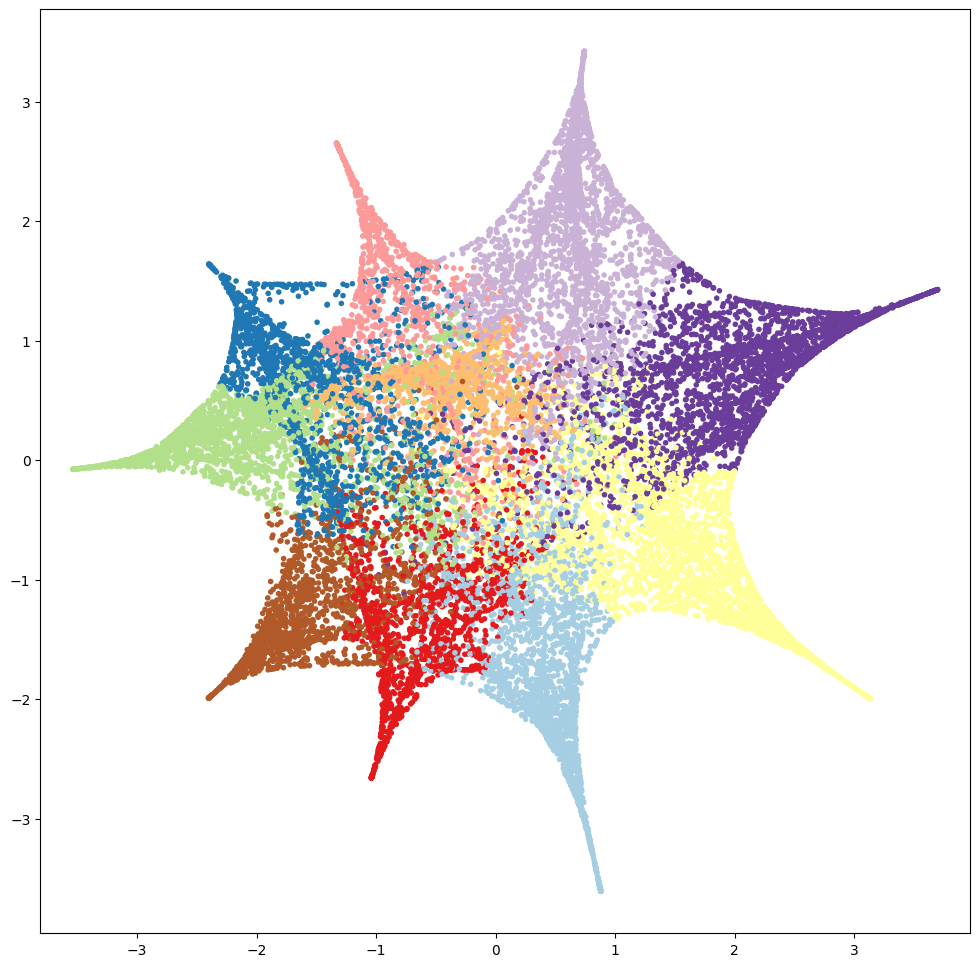

LDA model's perplexity:  -9.179704588293257


In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_100')
data_mangler = DataMangler(data_mangler_save_path)

calinski_harabasz_score or variance ratio for topic clusters:  9978.920765192659


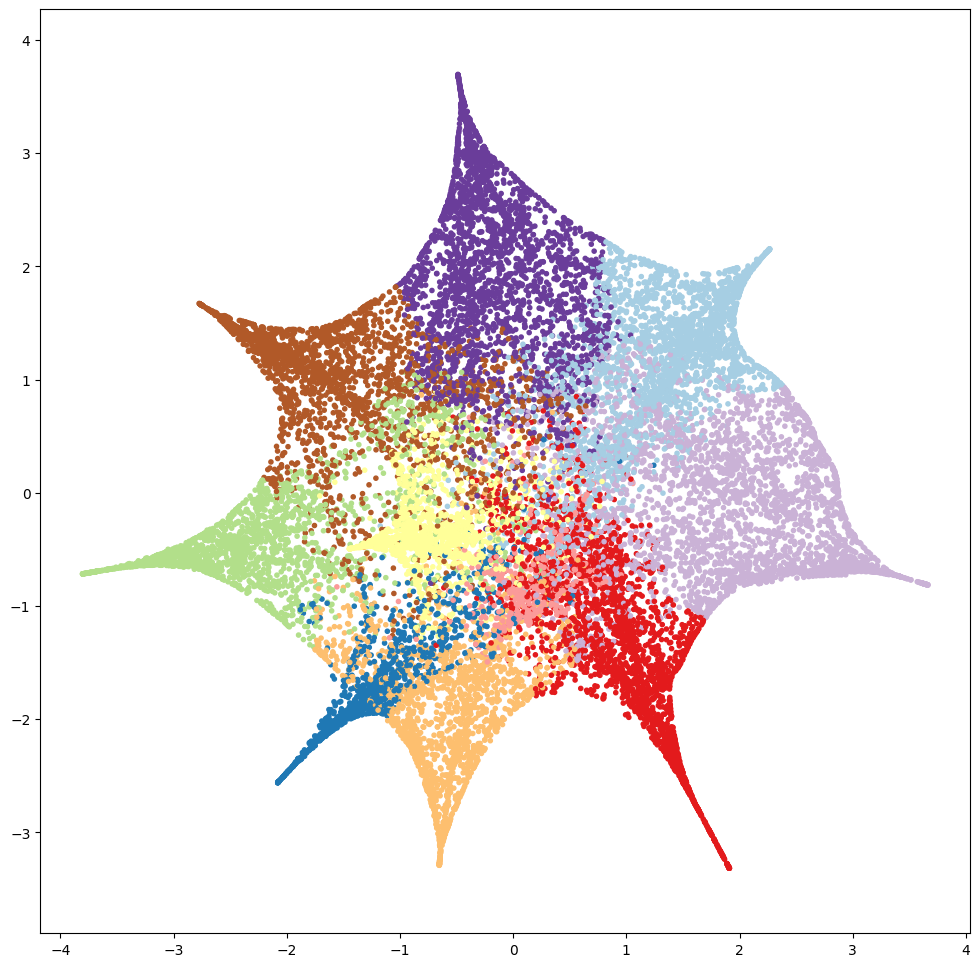

LDA model's perplexity:  -9.21305376373393


In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_500')
data_mangler = DataMangler(data_mangler_save_path)

calinski_harabasz_score or variance ratio for topic clusters:  11076.9366641376


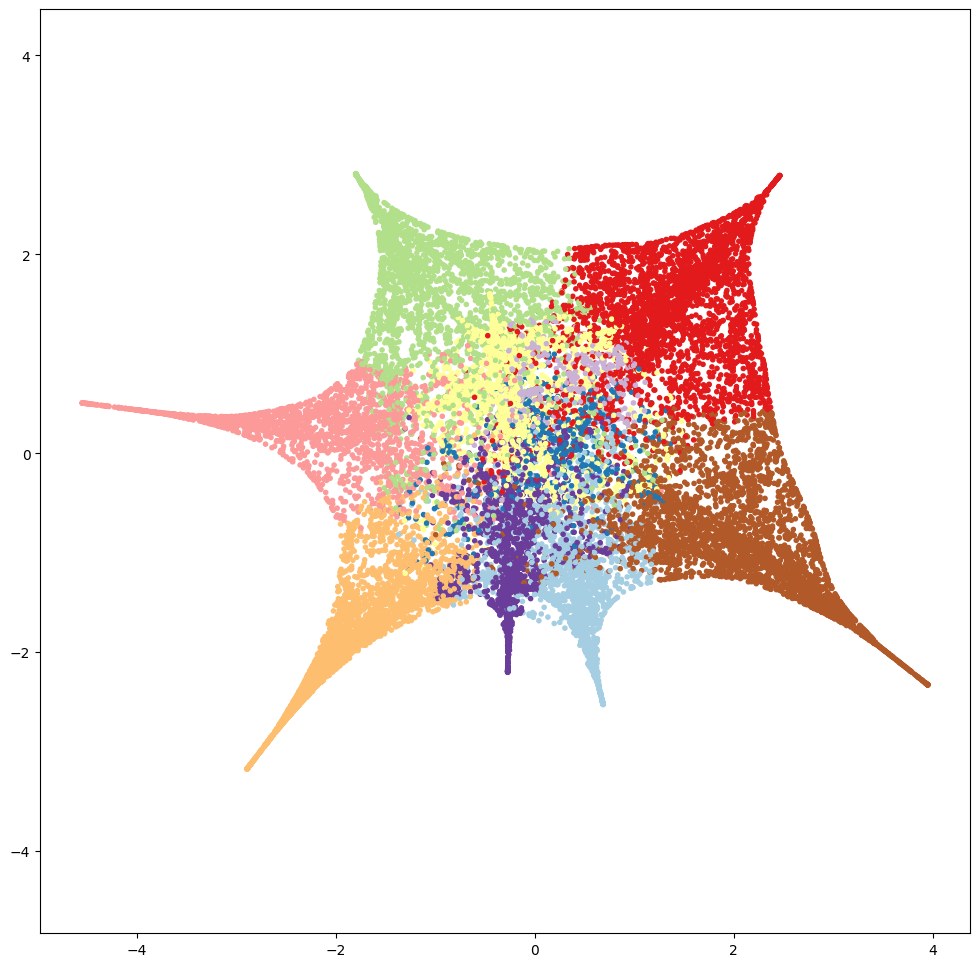

LDA model's perplexity:  -9.165928629596165


In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_1000')
data_mangler = DataMangler(data_mangler_save_path)

calinski_harabasz_score or variance ratio for topic clusters:  11897.491495928889


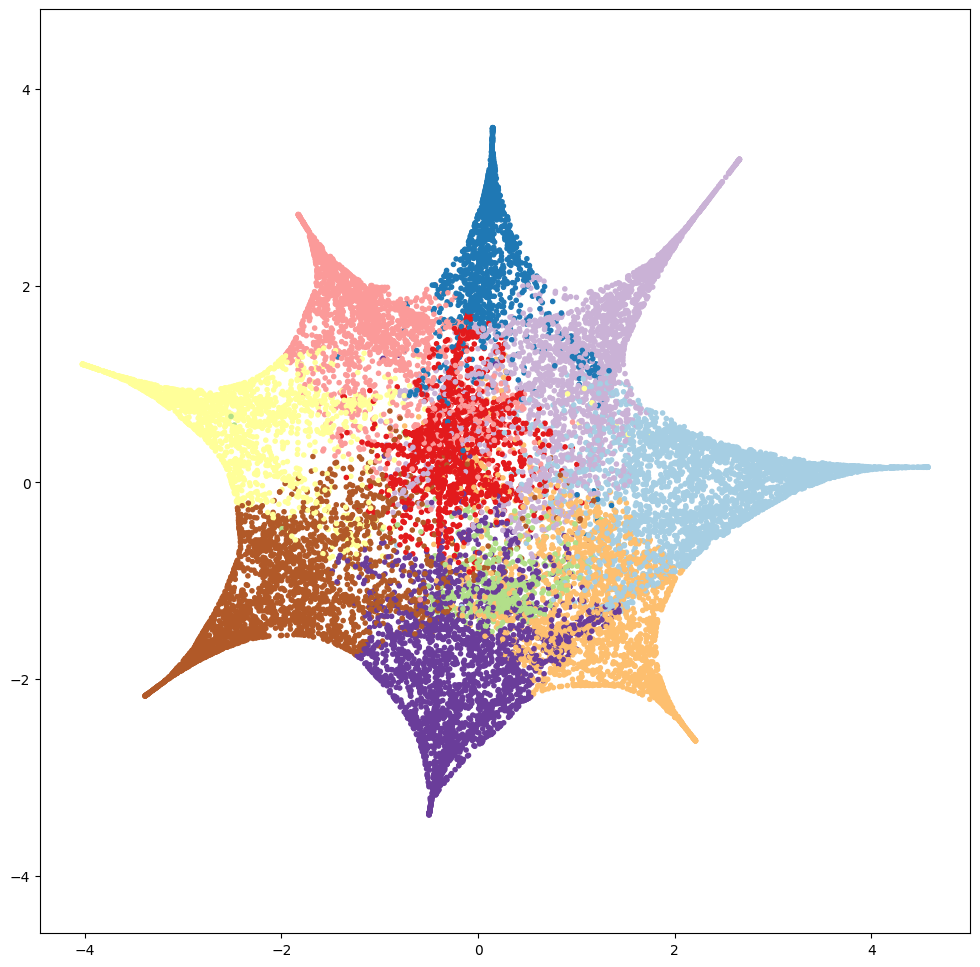

LDA model's perplexity:  -9.153757420495625


In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_2000')
data_mangler = DataMangler(data_mangler_save_path)

calinski_harabasz_score or variance ratio for topic clusters:  10709.925354417393


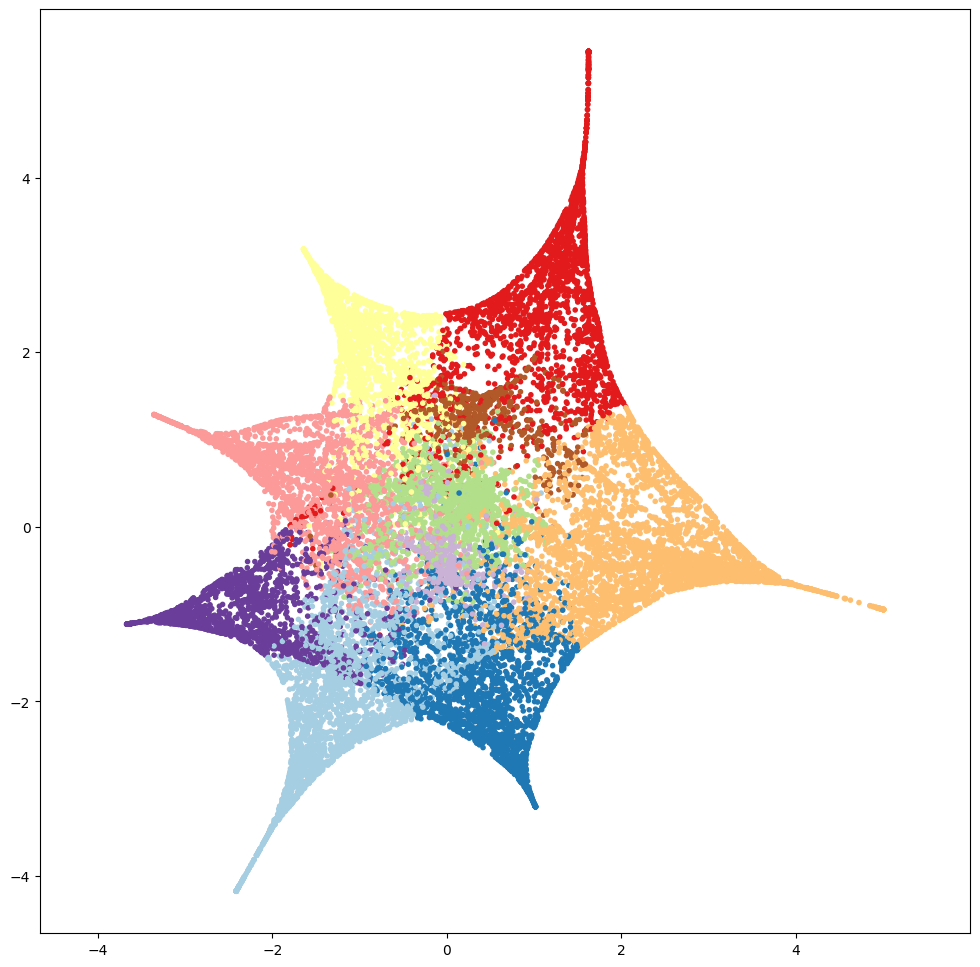

LDA model's perplexity:  -9.1438758326663


In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_4000')
data_mangler = DataMangler(data_mangler_save_path)

# Model training and evaluation

In [ ]:
data_mangler_save_path = os.path.join(drive_mount_path, 'My Drive/bhuvishi_polygence/data_mangler_save_dir_4000')
data_mangler = DataMangler(data_mangler_save_path, print_stats=False)

In [ ]:
from numba import cuda
print_gpu_utilization()
device = cuda.get_current_device()
device.reset()
print_gpu_utilization()

GPU memory occupied: 29195 MB.
GPU memory occupied: 449 MB.


In [ ]:
model = Model(
    model_checkpoint="distilbert-base-uncased",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=128,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7a7a84d1ca60>>, tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._ma

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 1036.35
Samples/second: 125.75
GPU memory occupied: 29645 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 55.74324324324324, 'f1': 58.79003606790423, 'total': 1776, 'HasAns_exact': 42.90220820189275, 'HasAns_f1': 48.59211783028176, 'HasAns_total': 951, 'NoAns_exact': 70.54545454545455, 'NoAns_f1': 70.54545454545455, 'NoAns_total': 825, 'best_exact': 55.968468468468465, 'best_exact_thresh': 0.0, 'best_f1': 58.94352288805768, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 53.480358373535495, 'f1': 57.357588213166835, 'total': 1451, 'HasAns_exact': 58.25242718446602, 'HasAns_f1': 66.05528501706674, 'HasAns_total': 721, 'NoAns_exact': 48.76712328767123, 'NoAns_f1': 48.76712328767123, 'NoAns_total': 730, 'best_exact': 53.756030323914544, 'best_exact_thresh': 0.0, 'best_f1': 57.525109641887376, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 55.46975546975547, 'f1': 60.055423844243734, 'total': 777, 'HasAns_exact': 61.49870801033592, 'HasAns_f1': 70.70559257616893, 'HasAns_total': 387, 'NoAns_exact': 49.48717948717949, 'NoAns_f1': 49.48717948717949, 'N

In [ ]:
model = Model(
    model_checkpoint="bert-base-uncased",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7e57e0361240>>, tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._map_single cou

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2091.65
Samples/second: 62.30
GPU memory occupied: 29195 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 64.58333333333333, 'f1': 68.17226944115517, 'total': 1776, 'HasAns_exact': 58.04416403785489, 'HasAns_f1': 64.74653052312466, 'HasAns_total': 951, 'NoAns_exact': 72.12121212121212, 'NoAns_f1': 72.12121212121212, 'NoAns_total': 825, 'best_exact': 64.75225225225225, 'best_exact_thresh': 0.0, 'best_f1': 68.29355300542126, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 63.47346657477602, 'f1': 67.39501915703259, 'total': 1451, 'HasAns_exact': 63.52288488210818, 'HasAns_f1': 71.41494146581734, 'HasAns_total': 721, 'NoAns_exact': 63.42465753424658, 'NoAns_f1': 63.42465753424658, 'NoAns_total': 730, 'best_exact': 63.54238456237078, 'best_exact_thresh': 0.0, 'best_f1': 67.4639371446273, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 64.22136422136423, 'f1': 67.7270741556456, 'total': 777, 'HasAns_exact': 74.93540051679587, 'HasAns_f1': 81.97399643136077, 'HasAns_total': 387, 'NoAns_exact': 53.58974358974359, 'NoAns_f1': 53.58974358974359, 'NoAns_tot

In [ ]:
model = Model(
    model_checkpoint="bert-large-uncased",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=32,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7f9c3c34fc10>>, tokenizer=BertTokenizerFast(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._map_single co

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 6733.40
Samples/second: 19.35
GPU memory occupied: 40733 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 76.29504504504504, 'f1': 79.6863488680957, 'total': 1776, 'HasAns_exact': 69.92639327024185, 'HasAns_f1': 76.2596799050872, 'HasAns_total': 951, 'NoAns_exact': 83.63636363636364, 'NoAns_f1': 83.63636363636364, 'NoAns_total': 825, 'best_exact': 76.29504504504504, 'best_exact_thresh': 0.0, 'best_f1': 79.68634886809579, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 74.77601654031702, 'f1': 77.64235739782124, 'total': 1451, 'HasAns_exact': 76.69902912621359, 'HasAns_f1': 82.46749040809794, 'HasAns_total': 721, 'NoAns_exact': 72.87671232876713, 'NoAns_f1': 72.87671232876713, 'NoAns_total': 730, 'best_exact': 74.84493452791179, 'best_exact_thresh': 0.0, 'best_f1': 77.71127538541597, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 70.91377091377092, 'f1': 73.57449453645826, 'total': 777, 'HasAns_exact': 84.75452196382429, 'HasAns_f1': 90.09659497371597, 'HasAns_total': 387, 'NoAns_exact': 57.17948717948718, 'NoAns_f1': 57.17948717948718, 'NoAns_tot

In [ ]:
model = Model(
    model_checkpoint="bert-large-uncased-whole-word-masking",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=32,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7be4c808b220>>, tokenizer=BertTokenizerFast(name_or_path='bert-large-uncased-whole-word-masking', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dat

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased-whole-word-masking and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 6750.45
Samples/second: 19.30
GPU memory occupied: 40733 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 80.85585585585585, 'f1': 83.56575677636583, 'total': 1776, 'HasAns_exact': 73.71188222923239, 'HasAns_f1': 78.77264356974308, 'HasAns_total': 951, 'NoAns_exact': 89.0909090909091, 'NoAns_f1': 89.0909090909091, 'NoAns_total': 825, 'best_exact': 80.96846846846847, 'best_exact_thresh': 0.0, 'best_f1': 83.6308860081618, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 81.3921433494142, 'f1': 84.54247771416567, 'total': 1451, 'HasAns_exact': 80.58252427184466, 'HasAns_f1': 86.92251756345958, 'HasAns_total': 721, 'NoAns_exact': 82.1917808219178, 'NoAns_f1': 82.1917808219178, 'NoAns_total': 730, 'best_exact': 81.3921433494142, 'best_exact_thresh': 0.0, 'best_f1': 84.54247771416564, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 81.20978120978121, 'f1': 83.63574638010728, 'total': 777, 'HasAns_exact': 88.88888888888889, 'HasAns_f1': 93.75962516109396, 'HasAns_total': 387, 'NoAns_exact': 73.58974358974359, 'NoAns_f1': 73.58974358974359, 'NoAns_total': 

In [ ]:
model = Model(
    model_checkpoint="bert-base-multilingual-uncased",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=32,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7f4cec556350>>, tokenizer=BertTokenizerFast(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2177.97
Samples/second: 59.84
GPU memory occupied: 16659 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 70.66441441441441, 'f1': 73.66982638891027, 'total': 1776, 'HasAns_exact': 61.9348054679285, 'HasAns_f1': 67.54743603228673, 'HasAns_total': 951, 'NoAns_exact': 80.72727272727273, 'NoAns_f1': 80.72727272727273, 'NoAns_total': 825, 'best_exact': 70.66441441441441, 'best_exact_thresh': 0.0, 'best_f1': 73.66982638891032, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 71.881461061337, 'f1': 75.66279171587725, 'total': 1451, 'HasAns_exact': 69.90291262135922, 'HasAns_f1': 77.5127750065713, 'HasAns_total': 721, 'NoAns_exact': 73.83561643835617, 'NoAns_f1': 73.83561643835617, 'NoAns_total': 730, 'best_exact': 71.881461061337, 'best_exact_thresh': 0.0, 'best_f1': 75.66279171587725, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 71.55727155727156, 'f1': 74.592625306911, 'total': 777, 'HasAns_exact': 80.10335917312662, 'HasAns_f1': 86.1975965464338, 'HasAns_total': 387, 'NoAns_exact': 63.07692307692308, 'NoAns_f1': 63.07692307692308, 'NoAns_total': 39

In [ ]:
# https://huggingface.co/ahmedrachid/FinancialBERT
model = Model(
    model_checkpoint="ahmedrachid/FinancialBERT",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7ac3d9f9d2a0>>, tokenizer=BertTokenizerFast(name_or_path='ahmedrachid/FinancialBERT', vocab_size=30873, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._map_si

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at ahmedrachid/FinancialBERT and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2093.17
Samples/second: 62.26
GPU memory occupied: 29197 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 54.67342342342342, 'f1': 57.887907696983575, 'total': 1776, 'HasAns_exact': 40.37854889589905, 'HasAns_f1': 46.38162362759509, 'HasAns_total': 951, 'NoAns_exact': 71.15151515151516, 'NoAns_f1': 71.15151515151516, 'NoAns_total': 825, 'best_exact': 54.84234234234234, 'best_exact_thresh': 0.0, 'best_f1': 57.94099650007239, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 52.929014472777396, 'f1': 56.33232450964199, 'total': 1451, 'HasAns_exact': 43.41192787794729, 'HasAns_f1': 50.26103032384273, 'HasAns_total': 721, 'NoAns_exact': 62.32876712328767, 'NoAns_f1': 62.32876712328767, 'NoAns_total': 730, 'best_exact': 53.13576843556168, 'best_exact_thresh': 0.0, 'best_f1': 56.401242497236716, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 54.95495495495496, 'f1': 58.388046917458716, 'total': 777, 'HasAns_exact': 54.78036175710594, 'HasAns_f1': 61.6731587981018, 'HasAns_total': 387, 'NoAns_exact': 55.12820512820513, 'NoAns_f1': 55.12820512820513, 'NoAn

In [ ]:
#https://huggingface.co/facebook/esm2_t36_3B_UR50D
model = Model(
    model_checkpoint="facebook/esm2_t36_3B_UR50D",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

AssertionError: ignored

In [ ]:
# https://huggingface.co/roberta-base
model = Model(
    model_checkpoint="roberta-base",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7a1dc5fa69e0>>, tokenizer=RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenizati

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2070.85
Samples/second: 62.93
GPU memory occupied: 29541 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 76.85810810810811, 'f1': 80.30203977179885, 'total': 1776, 'HasAns_exact': 70.97791798107255, 'HasAns_f1': 77.4094875233594, 'HasAns_total': 951, 'NoAns_exact': 83.63636363636364, 'NoAns_f1': 83.63636363636364, 'NoAns_total': 825, 'best_exact': 76.91441441441441, 'best_exact_thresh': 0.0, 'best_f1': 80.35834607810521, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 77.11922811853894, 'f1': 80.18391426458882, 'total': 1451, 'HasAns_exact': 77.94729542302358, 'HasAns_f1': 84.11492315938759, 'HasAns_total': 721, 'NoAns_exact': 76.3013698630137, 'NoAns_f1': 76.3013698630137, 'NoAns_total': 730, 'best_exact': 77.1881461061337, 'best_exact_thresh': 0.0, 'best_f1': 80.25283225218357, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 76.7052767052767, 'f1': 79.14210199924486, 'total': 777, 'HasAns_exact': 84.75452196382429, 'HasAns_f1': 89.64706267031848, 'HasAns_total': 387, 'NoAns_exact': 68.71794871794872, 'NoAns_f1': 68.71794871794872, 'NoAns_total'

In [ ]:
# https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
model = Model(
    model_checkpoint="emilyalsentzer/Bio_ClinicalBERT",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7cdf7f664ac0>>, tokenizer=BertTokenizerFast(name_or_path='emilyalsentzer/Bio_ClinicalBERT', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform data

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2093.25
Samples/second: 62.26
GPU memory occupied: 29191 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 63.682432432432435, 'f1': 67.33812588266699, 'total': 1776, 'HasAns_exact': 59.095688748685596, 'HasAns_f1': 65.92272509738862, 'HasAns_total': 951, 'NoAns_exact': 68.96969696969697, 'NoAns_f1': 68.96969696969697, 'NoAns_total': 825, 'best_exact': 63.79504504504504, 'best_exact_thresh': 0.0, 'best_f1': 67.41653762774541, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 60.234321157822194, 'f1': 64.24701837052768, 'total': 1451, 'HasAns_exact': 58.66851595006935, 'HasAns_f1': 66.74399952237971, 'HasAns_total': 721, 'NoAns_exact': 61.78082191780822, 'NoAns_f1': 61.78082191780822, 'NoAns_total': 730, 'best_exact': 60.44107512060648, 'best_exact_thresh': 0.0, 'best_f1': 64.45377233331192, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 61.51866151866152, 'f1': 66.1949033565575, 'total': 777, 'HasAns_exact': 70.02583979328165, 'HasAns_f1': 79.4145734058015, 'HasAns_total': 387, 'NoAns_exact': 53.07692307692308, 'NoAns_f1': 53.07692307692308, 'NoAns_

In [ ]:
# https://huggingface.co/nlpaueb/legal-bert-base-uncased
model = Model(
    model_checkpoint="nlpaueb/legal-bert-base-uncased",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7d943a750220>>, tokenizer=BertTokenizerFast(name_or_path='nlpaueb/legal-bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2095.63
Samples/second: 62.19
GPU memory occupied: 29195 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 67.62387387387388, 'f1': 70.49702031766168, 'total': 1776, 'HasAns_exact': 59.726603575184015, 'HasAns_f1': 65.09222721784137, 'HasAns_total': 951, 'NoAns_exact': 76.72727272727273, 'NoAns_f1': 76.72727272727273, 'NoAns_total': 825, 'best_exact': 67.62387387387388, 'best_exact_thresh': 0.0, 'best_f1': 70.49702031766174, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 65.74776016540316, 'f1': 69.24758257394123, 'total': 1451, 'HasAns_exact': 62.13592233009709, 'HasAns_f1': 69.17925425074729, 'HasAns_total': 721, 'NoAns_exact': 69.31506849315069, 'NoAns_f1': 69.31506849315069, 'NoAns_total': 730, 'best_exact': 65.81667815299794, 'best_exact_thresh': 0.0, 'best_f1': 69.31650056153593, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 64.99356499356499, 'f1': 68.4084645849352, 'total': 777, 'HasAns_exact': 74.4186046511628, 'HasAns_f1': 81.27487592375877, 'HasAns_total': 387, 'NoAns_exact': 55.64102564102564, 'NoAns_f1': 55.64102564102564, 'NoAns_to

In [ ]:
# https://huggingface.co/nlpaueb/sec-bert-base
model = Model(
    model_checkpoint="nlpaueb/sec-bert-base",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7e8b766ac400>>, tokenizer=BertTokenizerFast(name_or_path='nlpaueb/sec-bert-base', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._map_single

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at nlpaueb/sec-bert-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2095.03
Samples/second: 62.20
GPU memory occupied: 29193 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 66.61036036036036, 'f1': 69.81354364834085, 'total': 1776, 'HasAns_exact': 57.202944269190326, 'HasAns_f1': 63.18491432119172, 'HasAns_total': 951, 'NoAns_exact': 77.45454545454545, 'NoAns_f1': 77.45454545454545, 'NoAns_total': 825, 'best_exact': 66.66666666666667, 'best_exact_thresh': 0.0, 'best_f1': 69.86567911714306, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 64.2315644383184, 'f1': 67.26421668554028, 'total': 1451, 'HasAns_exact': 60.33287101248266, 'HasAns_f1': 66.43603108282802, 'HasAns_total': 721, 'NoAns_exact': 68.08219178082192, 'NoAns_f1': 68.08219178082192, 'NoAns_total': 730, 'best_exact': 64.36940041350793, 'best_exact_thresh': 0.0, 'best_f1': 67.40205266072978, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 66.28056628056628, 'f1': 69.60229734665825, 'total': 777, 'HasAns_exact': 71.57622739018088, 'HasAns_f1': 78.24543937559032, 'HasAns_total': 387, 'NoAns_exact': 61.02564102564103, 'NoAns_f1': 61.02564102564103, 'NoAns_t

In [ ]:
# https://huggingface.co/adsabs/astroBERT
model = Model(
    model_checkpoint="adsabs/astroBERT",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7ec3f4825f60>>, tokenizer=BertTokenizerFast(name_or_path='adsabs/astroBERT', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_data

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at adsabs/astroBERT and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2092.21
Samples/second: 62.29
GPU memory occupied: 29193 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-4-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 69.36936936936937, 'f1': 72.12262942760263, 'total': 1776, 'HasAns_exact': 58.14931650893796, 'HasAns_f1': 63.29105138109597, 'HasAns_total': 951, 'NoAns_exact': 82.3030303030303, 'NoAns_f1': 82.3030303030303, 'NoAns_total': 825, 'best_exact': 69.36936936936937, 'best_exact_thresh': 0.0, 'best_f1': 72.12262942760267, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 66.71261199172984, 'f1': 69.46104565861303, 'total': 1451, 'HasAns_exact': 60.74895977808599, 'HasAns_f1': 66.2801348830063, 'HasAns_total': 721, 'NoAns_exact': 72.6027397260274, 'NoAns_f1': 72.6027397260274, 'NoAns_total': 730, 'best_exact': 66.7815299793246, 'best_exact_thresh': 0.0, 'best_f1': 69.52996364620779, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 66.79536679536679, 'f1': 70.26679971416814, 'total': 777, 'HasAns_exact': 70.2842377260982, 'HasAns_f1': 77.25401389640479, 'HasAns_total': 387, 'NoAns_exact': 63.333333333333336, 'NoAns_f1': 63.333333333333336, 'NoAns_total'

In [ ]:
# https://huggingface.co/GroNLP/hateBERT
model = Model(
    model_checkpoint="GroNLP/hateBERT",
    dataset_dict=data_mangler.get_updated_dataset_dict(),
    num_train_epochs=1,
    batch_size=64,
    max_length=384,
    doc_stride=128,
    squad_v2=squad_v2)
print_gpu_utilization()

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=functools.partial(<bound method Model._prepare_train_features of <__main__.Model object at 0x7edab37815d0>>, tokenizer=BertTokenizerFast(name_or_path='GroNLP/hateBERT', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), max_length=384, doc_stride=128) of the transform datasets.arrow_dataset.Dataset._map_single could

Preparing training features


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Time: 2096.69
Samples/second: 62.16
GPU memory occupied: 29195 MB.
Making predictions on the validation data.


/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot locate reference to <class '_ctypes.PyCPointerType'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:412: PicklingWarning: Cannot pickle <class '_ctypes.PyCPointerType'>: _ctypes.PyCPointerType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Post-processing 11873 example predictions split into 11873 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Evaluating the model.


<ipython-input-5-83c089ea1e6c>:114: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if self._squad_v2 else "squad")


topic:  0 , result:  {'exact': 53.88513513513514, 'f1': 57.16295198430858, 'total': 1776, 'HasAns_exact': 46.79284963196635, 'HasAns_f1': 52.914198448088406, 'HasAns_total': 951, 'NoAns_exact': 62.06060606060606, 'NoAns_f1': 62.06060606060606, 'NoAns_total': 825, 'best_exact': 54.11036036036036, 'best_exact_thresh': 0.0, 'best_f1': 57.383845955202545, 'best_f1_thresh': 0.0}
topic:  1 , result:  {'exact': 47.89800137835975, 'f1': 52.069645845357655, 'total': 1451, 'HasAns_exact': 55.478502080443825, 'HasAns_f1': 63.873864246344006, 'HasAns_total': 721, 'NoAns_exact': 40.41095890410959, 'NoAns_f1': 40.41095890410959, 'NoAns_total': 730, 'best_exact': 50.654720882150244, 'best_exact_thresh': 0.0, 'best_f1': 52.40274945206562, 'best_f1_thresh': 0.0}
topic:  2 , result:  {'exact': 49.29214929214929, 'f1': 54.082991582991596, 'total': 777, 'HasAns_exact': 62.53229974160207, 'HasAns_f1': 72.15112263561876, 'HasAns_total': 387, 'NoAns_exact': 36.15384615384615, 'NoAns_f1': 36.15384615384615, '